# **Predicting shot outcomes from the 2018 FIFA World Cup using logistic regression**

This project outlines the steps involved in predicting shout outcomes using logisitic regression and shot data from the 2018 FIFA World Cup. The data for this project is provided by the StatsBomb [Open Data](https://github.com/statsbomb/open-data) repository. The framework for the project is inspired by [Devin Pleuler](https://twitter.com/devinpleuler)'s tutorial on logistic regression from his [Soccer Analytics Handbook](https://github.com/devinpleuler/analytics-handbook).


Logistic regression is used in classification problems when there are two possible labels for the target variable. In this case, the two possible labels are a goal or not a goal.

Given the features of the dataset, in this case, the distance from goal, the goal angle, and whether it was a headed shot or not, logistic regression will output a probability for the target variable. If the probability is greater than 0.5, the data is labelled as '1'; if the probability is less than 0.5, the data is labelled as '0'.

Logistic regression is used in a variety of machine learning applications and is a vital part of any data science toolbox.

Ok, let's get ready to ROC (first and last time, I promise).

## **Importing Data and Exploritory Data Analysis (EDA)**

In [1]:
# Import packages for EDA
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

The URLs below provide the locations where the raw StatsBomb data is stored.

In [2]:
# Define variables for reading in the Statsbomb data
base_url = "https://raw.githubusercontent.com/statsbomb/open-data/master/data/"
comp_url = base_url + "matches/{}/{}.json"
match_url = base_url + "events/{}.json"

This **parse_data** function below collects the following attributes of each shot from the Statsbomb data:
- x-coordinate
- y-coordinate
    - the pitch dimensions are 80 x 120
- if it was a headed shot
- the phase of play the shot was attempted in
- the outcome of the shot (goal or no goal)
- statsbomb_xg (Statsbomb's xG for comparison with the model's predictions)

In [3]:
def parse_data(competition_id, season_id):
    matches = requests.get(url=comp_url.format(competition_id, season_id)).json()
    match_ids = [m['match_id'] for m in matches]

    all_events = []
    for match_id in match_ids:

        events = requests.get(url=match_url.format(match_id)).json()
        shots = [x for x in events if x['type']['name'] == "Shot"]
                
        for s in shots:
            attributes = {
                "x": s['location'][0],
                "y": s['location'][1],
                "head": 1 if s['shot']['body_part']['name'] == "Head" else 0,
                "phase": s['shot']['type']['name'],
                "outcome": 1 if s['shot']['outcome']['name'] == "Goal" else 0,
                "statsbomb_xg": s['shot']['statsbomb_xg']
            }
            all_events.append(attributes)
            
    return pd.DataFrame(all_events)

- **43** is StatsBomb's Competition ID for the World Cup
- **3** is StatsBomb's Season ID for the 2018 Season

In [4]:
# Define the competition_id and season_id, and parse the data
competition_id = 43
season_id = 3
wc_2018 = parse_data(competition_id, season_id)

In [5]:
# Print summary statistics
description = wc_2018.describe()
print(description)

print("\n")

# Check the automatically assigned data types
info = wc_2018.info()
print(info)

print("\n")

                 x            y         head      outcome  statsbomb_xg
count  1706.000000  1706.000000  1706.000000  1706.000000   1706.000000
mean    103.964830    40.183470     0.181712     0.107268      0.110305
std       8.714564    10.270236     0.385720     0.309545      0.171226
min      59.000000    13.000000     0.000000     0.000000      0.007366
25%      97.000000    33.000000     0.000000     0.000000      0.025467
50%     105.000000    40.000000     0.000000     0.000000      0.047136
75%     111.000000    48.000000     0.000000     0.000000      0.104312
max     119.000000    69.000000     1.000000     1.000000      0.931740


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1706 entries, 0 to 1705
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   x             1706 non-null   float64
 1   y             1706 non-null   float64
 2   head          1706 non-null   int64  
 3   phase         1706 non-n

In [6]:
# Check for missing values
print("Count of missing values in each column of the dataset:")
wc_2018.isna().sum()

Count of missing values in each column of the dataset:


x               0
y               0
head            0
phase           0
outcome         0
statsbomb_xg    0
dtype: int64

In [7]:
# Determine the number of observations in the dataset
wc_2018.shape

(1706, 6)

In [8]:
# Get the value counts for each outcome, sorted in descending order
wc_2018['outcome'].value_counts().sort_values(ascending=False)

0    1523
1     183
Name: outcome, dtype: int64

There are 183 goals in this dataset.

In [9]:
# Get the value counts for each phase, sorted in descending order
wc_2018['phase'].value_counts().sort_values(ascending=False)

Open Play    1556
Free Kick      82
Penalty        68
Name: phase, dtype: int64

In [10]:
# Get the value counts for headed shots, sorted in descending order
wc_2018['head'].value_counts().sort_values(ascending=False)

0    1396
1     310
Name: head, dtype: int64

## **Data Manipulation**

This **distance_from_goal** function takes the x and y coordinates of a given shot and calculates how far from the center of the goal that shot is taken from.

In [11]:
def distance_from_goal(origin):
    dest = np.array([120., 40.])
    return np.sqrt(np.sum((origin - dest) ** 2))

The **goal_angle** function generates the angle of the goalmouth (in radians) that is available to the shooter at the time of the shot.

The angle is determined by one of the interior angles between a triangle bounded by the origin of the shot and the coordinates of each goal post.

In [12]:
def goal_angle(origin):
    p0 = np.array((120., 36.))  # Left Post
    p1 = np.array(origin, dtype=np.float)
    p2 = np.array((120., 44.))  # Right Post

    v0 = p0 - p1
    v1 = p2 - p1

    angle = np.abs(np.math.atan2(np.linalg.det([v0, v1]), np.dot(v0, v1)))
    
    return angle

New columns titled **distance_to_goal** and **goal_angle** are added to every row in the DataFrame using a technique called [broadcasting](https://numpy.org/devdocs/user/basics.broadcasting.html).

Broadcasting describes how numpy treats arrays with different shapes during arithmetic operations. Broadcasting provides a means of vectorizing array operations without making needless copies of data and usually leads to efficient algorithm implementations.

**lambda** functions are anonymous functions that you can declare dynamically and allow you to avoid looping over DataFrames. You can learn more about lambda functions [here](https://www.w3schools.com/python/python_lambda.asp) (I certainly did).

In [13]:
# Create new columns with lambda functions
wc_2018['distance_from_goal'] = wc_2018.apply(lambda row: distance_from_goal(row[['x', 'y']]), axis=1)
wc_2018['goal_angle'] = wc_2018.apply(lambda r: goal_angle(r[['x', 'y']]), axis=1)

In [14]:
# Filter the DataFrame to remove all rows that have 'Free Kick' or 'Penalty' as it's designated 'phase'
shots = wc_2018[~wc_2018['phase'].isin(['Free Kick', 'Penalty'])]

These samples are removed before model development starts because they will skew the results as most samples are taken from open play.

## **Model Development**

The steps involved with model development are:
- importing the necessary packages
- instantiating the classifier
- splitting the data into training and test sets
- normalizing the train and test features
- fitting the model t0 the training data
- predicting on the test set
- measuring the performance of the model

In [16]:
# Import required packages
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score

The first step in model development is to split the the **shots** DataFrame into two new DataFrames that represent the *features* the model will be trained on and the *labels* that the model is trying to predict.




In [18]:
# Split the data into features and labels
features = shots[['distance_from_goal', 'goal_angle', 'head']]
labels = shots['outcome']

In [19]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features,labels,test_size=0.25,random_state=42)

Since the logistic regression model applies *linear* weights to each variable, it is important to normalize the continuous features such as **distance_to_goal** and **goal_angle**, which are not normally distributed. 

This is important because, in soccer, there is a small difference between a shot taken 25 metres from goal versus a shot taken 30 metres from goal, but a *big* difference between a shot taken 5 metres from goal versus a shot taken 10 metres from goal, even though the difference in distance is 5 metres for both examples. Without normalizing these features, the model can't make that sort of distinction.

The **StandardScalar** function from the sklearn preprocessing package will be used to normalize the features for this model.

In [20]:
# Instantiate StandardScaler and use it to rescale X_train and X_test
scaler = StandardScaler()
rescaledX_train = scaler.fit_transform(X_train)
rescaledX_test = scaler.transform(X_test)

In [21]:
# Instantiate a Logistic Regression 'model'
model = LogisticRegression()
# Fit 'model' to the training set
fit = model.fit(rescaledX_train, y_train)
# Predict the test set labels 'y_pred'
y_pred = model.predict(rescaledX_test)
# Calculate the label predictions on the test set using the model.predict_proba() method 
predictions = model.predict_proba(rescaledX_test)[:, 1]
# Display the mean accuracy on the given test features and labels
fit.score(rescaledX_test, y_test)

0.9074550128534704

The model has a mean accuracy of 90.7%.

## **Model Performance**

Two metrics that can help measure the performance of binary classification predictive models are:
- the receiver operating characteristic (ROC) curve
- the area under the ROC curve (AUC)

### **ROC Curve**

The *ROC curve* is a graph that shows the performance of a classification model at all classification thresholds. The ROC curve plots the True Positive Rate (TPR) against the False Positive Rate (FPR) at different classification thresholds. Lowering the classification threshold classifies more items as positive, thus increasing both False Positives and True Positives.

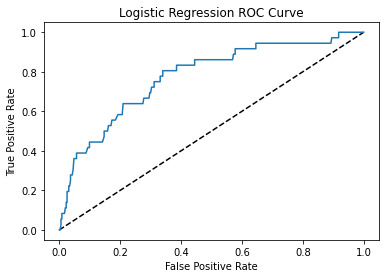

In [22]:
# Plotting the ROC curve
y_pred_prob = model.predict_proba(rescaledX_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot([0, 1], [0, 1],'k--')
plt.plot(fpr, tpr, label='Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
plt.show();

As you can see, the ROC curve provides a nice visual way to assess the classifier's performance.

### **Area under the ROC Curve (AUC)**

When it comes to the ROC curve, the larger the area under the curve, the better the model is. If the model produced an ROC curve that had a single point in the upper left corner, representing a true positive rate of one and a false positive rate of zero, this would be a very well performing model. 

For this reason the *area under the ROC* (AUC), is another popular metric for classification models. The first step in computing the AUC is to compute the predicted probabilities and then pass the true labels and the predicted probabilities to roc_auc_score from sklearn. 

In the simplest terms, if the AUC is greater than **0.5**, the model is better than random guessing.

In [23]:
roc_auc_score(y_test, y_pred_prob)

0.7744727730563425

The AUC of the logistic regression model is **0.77**.

AUC can also be calculated using cross-validation.

This is done with the function cross_val_score. The function takes the estimator, the features, and the target as arguments. Then set the number of folds, in this case five, and then set the scoring argument to 'roc_auc'.

In [24]:
# Cross-validation AUC scores
cv_scores = cross_val_score(model, features, labels, cv=5, scoring='roc_auc')

print(cv_scores)

[0.88293437 0.59966262 0.79709852 0.72287449 0.80636364]


The best performing model has an AUC of **0.88**.

## **Conclusion**

To wrap up, I have plotted the predictions and compared them to the xG provided by Statsbomb.

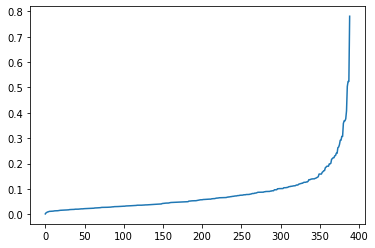

In [ ]:
plt.plot(sorted(predictions))
plt.show()

Above, you can see the model predicts that most shots are unlikely to result in a goal, and only a narrow range of opportunities have a goal probability of greater than '0.5'. Although this is a relatively small sample of shots, this model can provide insight on which shot locations, both from the perspective of distance and goal angle, provide the best probability of scoring.

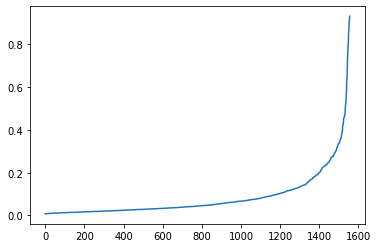

In [ ]:
plt.plot(sorted(shots['statsbomb_xg']))
plt.show()

When comparing the predicitons to StatsBomb's goal expectation estimates, the distributions are quite similar, which is exactly what we are looking for.

A model like this can provide insight on the characteristics of a shot that will most likely lead to a goal. 

This reminds me of the evolution in basketball that lead to a massive increase in both the number of three point attempts and the efficiency of three point shooting over the past decade. 

I hope that models like this can be a very small part of a shift towards more shots being taken in locations that are most likely to result in a goal and better conversion on those shots (defenders, look away).

> Here's to **more goals**!